## M07 Homework

### Michael Vaden, mtv2eva

In [85]:
import pandas as pd
import numpy as np
from glob import glob
import re
import nltk
import plotly_express as px
from lib.textparser import TextParser
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

from numpy.linalg import norm
from scipy.spatial.distance import pdist
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
from scipy.linalg import eigh
from sklearn.decomposition import PCA
import seaborn as sns

In [86]:
import configparser
config = configparser.ConfigParser()
config.read("../env.ini")
data_home = config['DEFAULT']['data_home']
output_dir = config['DEFAULT']['output_dir']
data_prefix = 'novels'

Import the LIB and CORPUS tables from the provided CSV files.
The index OHCO for CORPUS is ['book_id','chapter_id','para_num','sent_num','token_num']
The index for LIB is 'book_id'.

In [87]:
OHCO = ['book_id','chap_id','para_num','sent_num','token_num']

In [88]:
LIB = pd.read_csv(f"{data_home}/{data_prefix}-LIB.csv").set_index('book_id')
CORPUS = pd.read_csv(f"{data_home}/{data_prefix}-CORPUS.csv").set_index(OHCO)

In [89]:
LIB

,genre_id,author_id
book_id,,
secretadversary,d,christie
styles,d,christie
moonstone,d,collins
adventures,d,doyle
baskervilles,d,doyle
scarlet,d,doyle
signoffour,d,doyle
marieroget,d,poe
ruemorgue,d,poe


In [90]:
CORPUS

pos     term_str
book_id         chap_id para_num sent_num token_num                  
secretadversary 1       0        1        0           DT          the
                                          1          NNP        young
                                          2          NNP  adventurers
                                          3          NNP          ltd
                        1        0        0           JJ        tommy
...                                                  ...          ...
baskervilles    11      114      1        7          RBR         more
                                          8           JJ  comfortable
                                          9           IN      outside
                                          10          IN         than
                                          11          NN           in

[1500417 rows x 2 columns]

Extract a VOCAB table and add max_pos as a feature.

In [91]:
CORPUS = CORPUS[CORPUS.term_str != '']
CORPUS['pos_group'] = CORPUS.pos.str[:2]


VOCAB = CORPUS.term_str.value_counts().to_frame('n').sort_index()
VOCAB.index.name = 'term_str'
VOCAB['n_chars'] = VOCAB.index.str.len()
VOCAB['p'] = VOCAB.n / VOCAB.n.sum()
VOCAB['i'] = -np.log2(VOCAB.p)

VOCAB['max_pos'] = CORPUS[['term_str','pos']].value_counts().unstack(fill_value=0).idxmax(1)

In [92]:
VOCAB

,n,n_chars,p,i,max_pos
term_str,,,,,
a,28533,1,1.901674e-02,5.716586,DT
aback,9,5,5.998340e-06,17.347005,NN
abaft,2,5,1.332965e-06,19.516930,IN
abandon,44,7,2.932522e-05,15.057499,VB
abandoned,68,9,4.532079e-05,14.429467,VBN
...,...,...,...,...,...
à,3,1,1.999447e-06,18.931968,NNP
æt,1,2,6.664823e-07,20.516930,NN
ætat,1,4,6.664823e-07,20.516930,VBD


Compute TFIDF and VOCAB['dfidf'] for the CORPUS using the following parameters:

bag = ['book_id', 'chap_id']

tf_method = 'max'

idf_method = 'standard'

In [93]:
def create_bag_of_words(CORPUS, bag):
    BOW = CORPUS.groupby(bag+['term_str']).term_str.count().to_frame('n')
    return BOW

idf_method = 'standard' 

def get_TFIDF(BOW, tf_method):
    DTCM = BOW.n.unstack(fill_value=0)

    DF = DTCM.astype('bool').sum() 
    N = len(DTCM)

    if tf_method == 'sum':
        TF = DTCM.T / DTCM.T.sum()

    elif tf_method == 'max':
        TF = DTCM.T / DTCM.T.max()
        
    elif tf_method == 'log':
        TF = np.log2(1 + DTCM.T)
        
    elif tf_method == 'raw':
        TF = DTCM.T
        
    elif tf_method == 'double_norm':
        TF = DTCM.T / DTCM.T.max()
        
    elif tf_method == 'binary':
        TF = DTCM.T.astype('bool').astype('int')
    
    TF = TF.T

    if idf_method == 'standard':
        IDF = np.log2(N / DF)

    elif idf_method == 'max':
        IDF = np.log2(DF.max() / DF) 

    elif idf_method == 'smooth':
        IDF = np.log2((1 + N) / (1 + DF)) + 1

    return TF * IDF, DF * IDF

In [94]:
TFIDF, DFIDF = get_TFIDF(create_bag_of_words(CORPUS, ['book_id', 'chap_id']), 'max')

TFIDF

term_str              a  aback  abaft  abandon  abandoned  abandoning  \
book_id    chap_id                                                      
adventures 1        0.0    0.0    0.0  0.00000   0.006493         0.0   
           2        0.0    0.0    0.0  0.00000   0.000000         0.0   
           3        0.0    0.0    0.0  0.00000   0.000000         0.0   
           4        0.0    0.0    0.0  0.00000   0.000000         0.0   
           5        0.0    0.0    0.0  0.00000   0.000000         0.0   
...                 ...    ...    ...      ...        ...         ...   
udolpho    54       0.0    0.0    0.0  0.00000   0.000000         0.0   
           55       0.0    0.0    0.0  0.00000   0.009341         0.0   
           56       0.0    0.0    0.0  0.00000   0.000000         0.0   
           57       0.0    0.0    0.0  0.00000   0.000000         0.0   
usher      1        0.0    0.0    0.0  0.01253   0.000000         0.0   

term_str            abandons  abasement  abashed  abate  ...  zoöphagy  \
book_id    chap_id                                       ...             
adventures 1             0.0        0.0      0.0    0.0  ...       0.0   
           2             0.0        0.0      0.0    0.0  ...       0.0   
           3             0.0        0.0      0.0    0.0  ...       0.0   
           4             0.0        0.0      0.0    0.0  ...       0.0   
           5             0.0        0.0      0.0    0.0  ...       0.0   
...                      ...        ...      ...    ...  ...       ...   
udolpho    54            0.0        0.0      0.0    0.0  ...       0.0   
           55            0.0        0.0      0.0    0.0  ...       0.0   
           56            0.0        0.0      0.0    0.0  ...       0.0   
           57            0.0        0.0      0.0    0.0  ...       0.0   
usher      1             0.0        0.0      0.0    0.0  ...       0.0   

term_str            zufalle  zum  zuniga  zusammen    à   æt  ætat   ça  \
book_id    chap_id                                                        
adventures 1            0.0  0.0     0.0       0.0  0.0  0.0   0.0  0.0   
           2            0.0  0.0     0.0       0.0  0.0  0.0   0.0  0.0   
           3            0.0  0.0     0.0       0.0  0.0  0.0   0.0  0.0   
           4            0.0  0.0     0.0       0.0  0.0  0.0   0.0  0.0   
           5            0.0  0.0     0.0       0.0  0.0  0.0   0.0  0.0   
...                     ...  ...     ...       ...  ...  ...   ...  ...   
udolpho    54           0.0  0.0     0.0       0.0  0.0  0.0   0.0  0.0   
           55           0.0  0.0     0.0       0.0  0.0  0.0   0.0  0.0   
           56           0.0  0.0     0.0       0.0  0.0  0.0   0.0  0.0   
           57           0.0  0.0     0.0       0.0  0.0  0.0   0.0  0.0   
usher      1            0.0  0.0     0.0       0.0  0.0  0.0   0.0  0.0   

term_str            émeutes  
book_id    chap_id           
adventures 1            0.0  
           2            0.0  
           3            0.0  
           4            0.0  
           5            0.0  
...                     ...  
udolpho    54           0.0  
           55           0.0  
           56           0.0  
           57           0.0  
usher      1            0.0  

[320 rows x 27396 columns]

Create a DOC table from the TFIDF index in which each row represents a bag, i.e. a chapter. In other words, it should have ['book_id', 'chap_id'] as its index. This table should have information from the LIB table added to it, so that each chapter is identified with an author, title, and genre. These data will appear in your visualizations. For example, in a scatter plot of documents in the first two principle components, you will want to know the book and chapter of each data point.

In [95]:
DOC = TFIDF.reset_index()[['book_id','chap_id']]
DOC = DOC.merge(LIB, on='book_id', how='left')
DOC.set_index(['book_id','chap_id'],inplace=True)
DOC

genre_id  author_id
book_id    chap_id                    
adventures 1              d      doyle
           2              d      doyle
           3              d      doyle
           4              d      doyle
           5              d      doyle
...                     ...        ...
udolpho    54             g  radcliffe
           55             g  radcliffe
           56             g  radcliffe
           57             g  radcliffe
usher      1              g        poe

[320 rows x 2 columns]

Create a reduced version of the TFIDF table with only the top 1000 nouns (i.e. NN and NNS) in descending order of DFIDF.

Do not "collapse" table -- keep the index as (book_id, chap_id).

In [96]:
nouns = ['NN', 'NNS']
top1000 = VOCAB.merge(DFIDF.to_frame('DFIDF'), on='term_str').query("max_pos in @nouns").sort_values('DFIDF', ascending=False).head(1000).index.tolist()
TFIDF = TFIDF[[col for col in top1000]]
TFIDF

term_str               yours     reply     order  curiosity    memory  \
book_id    chap_id                                                      
adventures 1        0.006454  0.000000  0.003227   0.003227  0.006400   
           2        0.009346  0.000000  0.009346   0.000000  0.006178   
           3        0.004089  0.008178  0.000000   0.000000  0.004054   
           4        0.002721  0.002721  0.005442   0.000000  0.002698   
           5        0.003043  0.000000  0.003043   0.003043  0.003017   
...                      ...       ...       ...        ...       ...   
udolpho    54       0.007676  0.003838  0.003838   0.003838  0.003806   
           55       0.000000  0.000000  0.000000   0.004643  0.000000   
           56       0.000000  0.007822  0.000000   0.000000  0.000000   
           57       0.000000  0.000000  0.000000   0.000000  0.033189   
usher      1        0.000000  0.002566  0.002566   0.000000  0.002544   

term_str             company  feelings  opportunity      book    spirit  ...  \
book_id    chap_id                                                       ...   
adventures 1        0.006400  0.000000     0.000000  0.003282  0.003282  ...   
           2        0.000000  0.000000     0.000000  0.000000  0.000000  ...   
           3        0.008109  0.000000     0.000000  0.004159  0.000000  ...   
           4        0.000000  0.000000     0.002767  0.000000  0.000000  ...   
           5        0.000000  0.000000     0.000000  0.006190  0.000000  ...   
...                      ...       ...          ...       ...       ...  ...   
udolpho    54       0.003806  0.007611     0.007808  0.000000  0.000000  ...   
           55       0.004604  0.000000     0.000000  0.000000  0.004722  ...   
           56       0.015512  0.000000     0.000000  0.000000  0.015912  ...   
           57       0.000000  0.000000     0.000000  0.000000  0.000000  ...   
usher      1        0.000000  0.005088     0.002610  0.005219  0.015657  ...   

term_str            humanity      rank  contempt  apprehensions  owner  \
book_id    chap_id                                                       
adventures 1        0.000000  0.000000  0.000000       0.000000    0.0   
           2        0.000000  0.000000  0.000000       0.000000    0.0   
           3        0.000000  0.000000  0.000000       0.000000    0.0   
           4        0.000000  0.000000  0.000000       0.000000    0.0   
           5        0.000000  0.000000  0.000000       0.000000    0.0   
...                      ...       ...       ...            ...    ...   
udolpho    54       0.017027  0.000000  0.000000       0.008514    0.0   
           55       0.000000  0.000000  0.010299       0.000000    0.0   
           56       0.000000  0.000000  0.017351       0.000000    0.0   
           57       0.000000  0.000000  0.000000       0.000000    0.0   
usher      1        0.005691  0.011382  0.000000       0.000000    0.0   

term_str                 lad   enquiry       bag  investigation  inclination  
book_id    chap_id                                                            
adventures 1        0.000000  0.000000  0.007158       0.007158     0.000000  
           2        0.006910  0.000000  0.000000       0.000000     0.000000  
           3        0.000000  0.000000  0.000000       0.009070     0.000000  
           4        0.030176  0.000000  0.000000       0.006035     0.000000  
           5        0.000000  0.000000  0.006750       0.000000     0.000000  
...                      ...       ...       ...            ...          ...  
udolpho    54       0.000000  0.008514  0.000000       0.000000     0.008514  
           55       0.000000  0.010299  0.000000       0.000000     0.000000  
           56       0.000000  0.000000  0.000000       0.000000     0.000000  
           57       0.000000  0.000000  0.000000       0.000000     0.000000  
usher      1        0.000000  0.000000  0.000000       0.005691     0.000000  

[320 rows x 1000 c

Write a function that computes PCA from a given document-term count matrix (this included weighted counts, such a tfidf). It should return three dataframes: LOADINGS (the term-component matrix), DCM (the document-component matrix), COMPINF (the component information table). Give it the following parameters:

X # The input matrix

k # The number of components to generate

norm_docs # True or False

center_by_mean # True of False

center_by_variance # True or False

Compute PCA from the feature-reduced TFIDF table using your function. Use the following parameter values:
X = TFIDF_REDUCED Or whatever you called your reduced TFIDF table
k=10
norm_docs = True
center_by_mean = False
center_by_variance = False
Visualize your results using scatter plots and box plots.

In [108]:
def get_PCA(X, k, norm_docs = True, center_by_mean = True, center_by_variance = True):
    if norm_docs:
        X = (X.T / np.linalg.norm(X, 2, axis=1)).T
    
    if center_by_mean:
        X = X - X.mean(axis=0)
    
    if center_by_variance:
        X = X / X.std(axis=0)

    pca = PCA(n_components=k)
    pca.fit(X)
    
    loadings = pd.DataFrame(pca.components_.T, index=X.columns)
    loadings.columns = [f'PC{i+1}' for i in range(k)]
    
    dcm = pd.DataFrame(pca.transform(X), index=X.index)
    dcm.columns = [f'PC{i+1}' for i in range(k)]
    
    comp = pd.DataFrame({
        'EVR': pca.explained_variance_ratio_,
        'CEVR': np.cumsum(pca.explained_variance_ratio_)
    }, index=[f'PC{i+1}' for i in range(k)])
    
    return loadings, dcm, comp

LOADINGS, DCM, COMPINF = get_PCA(X=TFIDF, k=10, norm_docs=True, center_by_mean=False, center_by_variance=False)
DCM = DOC.join(DCM)

In [98]:
DCM

genre_id  author_id       PC1       PC2       PC3  \
book_id    chap_id                                                     
adventures 1              d      doyle -0.237319  0.038768  0.092062   
           2              d      doyle -0.295389  0.074901  0.035613   
           3              d      doyle -0.291923 -0.074162  0.035053   
           4              d      doyle -0.162984 -0.025831  0.026673   
           5              d      doyle -0.186560  0.049075  0.012450   
...                     ...        ...       ...       ...       ...   
udolpho    54             g  radcliffe  0.379714 -0.132359 -0.030655   
           55             g  radcliffe  0.303586 -0.185496  0.050914   
           56             g  radcliffe  0.391705  0.145064 -0.276399   
           57             g  radcliffe  0.286226  0.017426 -0.042757   
usher      1              g        poe  0.132124  0.119597  0.032166   

                         PC4       PC5       PC6       PC7       PC8  \
book_id    chap_id                                                     
adventures 1        0.029442 -0.191567  0.093441 -0.118399  0.011765   
           2        0.001857 -0.204501  0.066934 -0.111104 -0.109326   
           3        0.008414 -0.149578  0.112748 -0.103293 -0.041946   
           4        0.081026 -0.141952  0.057792 -0.204866 -0.071068   
           5        0.066207 -0.145323  0.097464 -0.043226 -0.144036   
...                      ...       ...       ...       ...       ...   
udolpho    54      -0.065428  0.040511  0.206042 -0.063613 -0.036247   
           55       0.036115  0.065106  0.181303 -0.023661 -0.113286   
           56      -0.235498 -0.109495  0.141362  0.046051  0.030292   
           57      -0.112652  0.019443  0.009336 -0.095355 -0.012079   
usher      1        0.126673 -0.018076  0.044846 -0.036131 -0.058944   

                         PC9      PC10  
book_id    chap_id                      
adventures 1       -0.021905 -0.028254  
           2       -0.020459  0.026691  
           3        0.000359  0.040192  
           4        0.158094  0.085781  
           5        0.006083  0.152767  
...                      ...       ...  
udolpho    54       0.028850 -0.000011  
           55       0.074211 -0.011379  
           56      -0.016949  0.121353  
           57      -0.051540  0.123404  
usher      1       -0.032415 -0.193522  

[320 rows x 12 columns]

### 1. Looking at the documents plotted against the first principle component (PC), which genre has the more narrow range, i.e. distance between the minimum and maximum values? This can be seen using a box plot

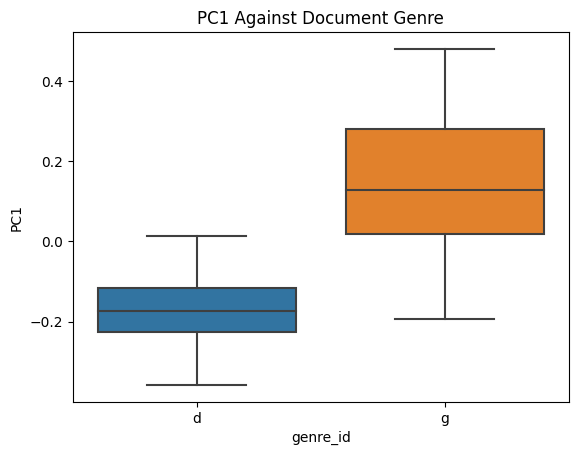

In [99]:
sns.boxplot(data=DCM, x = 'genre_id', y = 'PC1')
plt.title('PC1 Against Document Genre')
plt.show()

We can see from the boxplot above for the first principle component that the **d (detective)** genre has a more narrow range between the minimum and maximum values for the first principle component.

### 2. Looking at the documents plotted against the first PC, which author has the highest absolute value, in terms of both mean and range? In other words, which author is farthest from 0? Again, the box plots of each author are useful here.

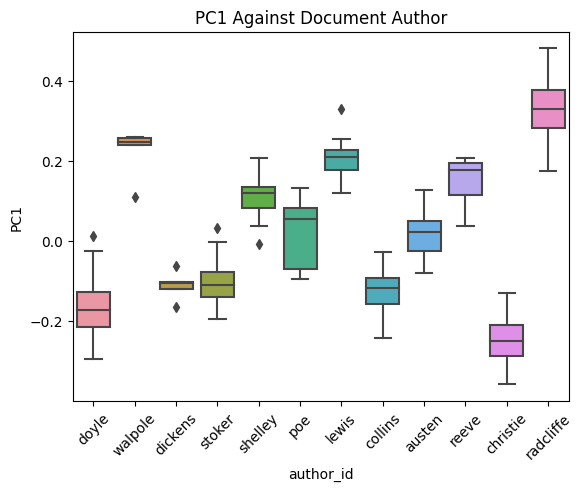

In [100]:
sns.boxplot(data=DCM, x = 'author_id', y = 'PC1')
plt.title('PC1 Against Document Author')
plt.xticks(rotation=45) 
plt.show()

We can see from the boxplot above for the first principle component that the author **Radcliffe** has both the highest absolute mean value of mean and range.

### 3. In the third PC, which author has, by far, the maximum range?

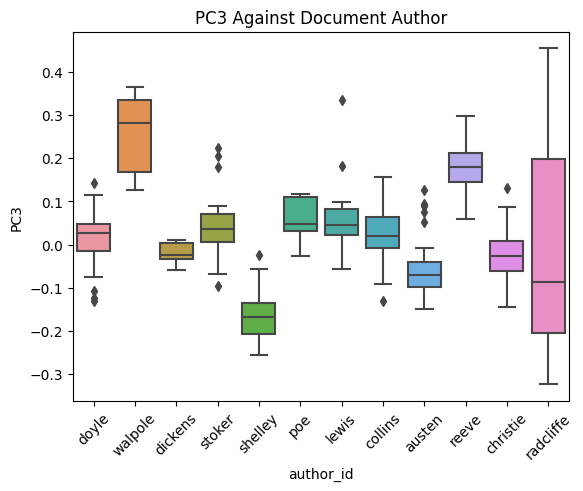

In [107]:
sns.boxplot(data=DCM, x = 'author_id', y = 'PC3')
plt.title('PC3 Against Document Author')
plt.xticks(rotation=45) 
plt.show()

We can see from the boxplot above for the third principle component that the author **Radcliffe** has the highest maximum range by far

### 4. Looking at the loadings for the second PC, how would you characterize the opposition, based on the top three words at each pole?

In [102]:
LOADINGS['PC2'].sort_values(ascending=False).to_frame().head(3)

,PC2
term_str,
mountains,0.176642
woods,0.140543
sea,0.103898


In [103]:
LOADINGS['PC2'].sort_values(ascending=True).to_frame().head(3)

,PC2
term_str,
brother,-0.153843
engagement,-0.115630
father,-0.113204


For the loadings of the second principle component, we can see that there is a the strongest positive terms are related to nature. In contrast, we can see that the strongest negative terms are all related to family. We can see a potential contrast here for the opposition between nature and family

### 5. Recompute the principle components with center_by_variance set to True. This will change the words that appear at the extremes of the first PC. Does this change your interpretation in the previous question?

In [104]:
LOADINGS5, DCM5, COMPINF5 = get_PCA(X=TFIDF, k=10, norm_docs=True, center_by_mean=False, center_by_variance=True)
DCM5 = DOC.join(DCM5)

In [105]:
LOADINGS5['PC1'].sort_values(ascending=False).to_frame().head(3)

,PC1
term_str,
countenance,0.095031
length,0.094551
melancholy,0.087428


In [106]:
LOADINGS5['PC1'].sort_values(ascending=True).to_frame().head(3)

,PC1
term_str,
matter,-0.085165
anything,-0.082012
course,-0.075488


*instructions unclear, recomputing PCA and examining extremes at first PC*. Compared to the previous question, we do not see clear themes of family or nature. Rather, the extremes of the first PC do not have as much of an association with eachother that we can discern when we are centered by variance.